In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
import scipy.stats as stats
import sys

sys.path.append("../")
import vuong_tests5

In [2]:
class OLS_loglike(GenericLikelihoodModel):
    
    def __init__(self, *args,ols=False, **kwargs):
        super(OLS_loglike,self).__init__(*args,**kwargs)
        self.ols = ols

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        mu_y = np.matmul(x,params)  
        resid = y - mu_y
        sigma = np.sqrt(np.sum(resid**2)/resid.shape[0])
        pr_y = stats.norm.logpdf( resid, loc=0,scale=sigma )
        return pr_y

In [3]:
def setup_model(yn,xn):
    """setup models for ease"""
    model1 = sm.OLS(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    params1 = (model1_fit.params)
    model1_deriv = OLS_loglike(yn,sm.add_constant(xn))
    ll1 = model1_deriv.loglikeobs(model1_fit.params)
    grad1 =  model1_deriv.score_obs(model1_fit.params)    
    hess1 = model1_deriv.hessian(model1_fit.params)
    return ll1,grad1,hess1,params1,model1_fit.resid


def setup_test(yn,xn):
    lls = []
    grads = []
    hesss = []
    params = []
    resids = []
    
    x1 = np.array([xn,xn**2,xn**3]).transpose()
    x2 = np.array([xn,xn**2,xn**3,xn**4]).transpose()
    for xi in (x1,x2) : 
        #fit cubic and quadratic terms?
        ll,grad,hess,param,resid = setup_model(yn,xi)
        lls.append(ll)
        grads.append(grad)
        hesss.append(hess)
        params.append(param)
        resids.append(resid)
    
    #determine 1 and 2
    ind1 = 0
    ind2 = 1
    return (lls[ind1],grads[ind1],hesss[ind1],params[ind1],resids[ind1],
            lls[ind2],grads[ind2],hesss[ind2],params[ind2],resids[ind2])

def gen_data(nobs=1000, a=0.25):
    x = np.random.normal(scale=1., size=(nobs))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + a*(x + x**2) + e #truth is quadratic
    return y,x,nobs

yn,xn,nobs = gen_data()
res = setup_test(yn,xn)

In [4]:
def test_mse(resid1,resid2):
    nobs = resid1.shape[0]
    llr = -1*(resid1**2 - resid2**2).sum()
    omega = np.clip(np.sqrt((resid1**2 - resid2**2).var()),.1,10000)
    test_stat = llr/(omega*np.sqrt(nobs))
    return 1*(test_stat >= 1.96) + 2*( test_stat <= -1.96)


In [5]:
def plot_true2(gen_data,setup_test,trials=500):
    llr_stats=[]
    mse_stats=[]
    for i in range(trials):
        np.random.seed()
        ys,xs,nobs = gen_data()
        ll1,grad1,hess1,params1,resid1,ll2,grad2,hess2,params2,resid2 = setup_test(ys,xs)
        
        ##Classical test
        V = vuong_tests5.compute_eigen2(ll1,grad1,hess1,params1,ll2, grad2,hess2,params2)
        llr = (ll1 - ll2).sum() +V.sum()/(2)
        omega2 = (ll1 - ll2).var() 
        nomega = np.clip( (np.sqrt(omega2*nobs)), .1,10000 )
        #print(llr/nomega)
        llr_stats.append(llr/nomega)
        
        ## MSE test
        mse = -1*(resid1**2 - resid2**2).sum()
        omega2 = (resid1**2 - resid2**2).var() 
        nomega = np.clip( (np.sqrt(omega2*nobs)), .1,10000 )
        mse_stats.append(mse/nomega)
    plt.hist(llr_stats, density=True,bins=15, label="LLR",alpha=.60)
    plt.hist(mse_stats, density=True,bins=15, label="MSE",alpha=.60)
    plt.legend()
    plt.show()
    return mse_stats,llr_stats




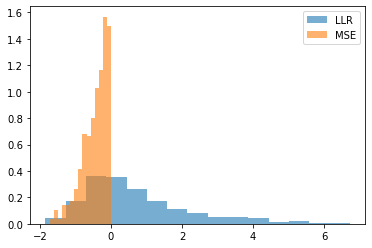

In [6]:
gen_data_ex = lambda : gen_data(nobs=1000, a=0.0)
mse_stats,llr_stats = plot_true2(gen_data_ex,setup_test)

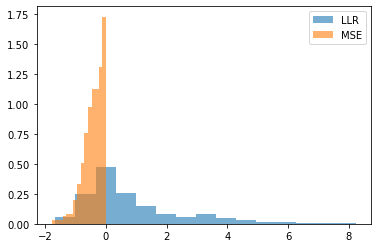

In [7]:
gen_data_ex = lambda : gen_data(nobs=1000, a=0.25)
mse_stats,llr_stats = plot_true2(gen_data_ex,setup_test)

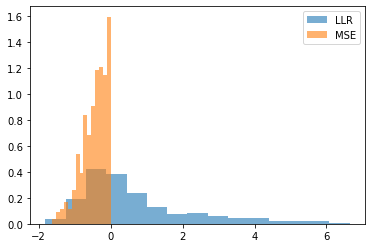

In [8]:
gen_data_ex = lambda : gen_data(nobs=1000, a=0.5)
mse_stats,llr_stats = plot_true2(gen_data_ex,setup_test)

# Power

In [9]:
def gen_data2(nobs=1000, a=0.25):
    x = np.random.normal(scale=1., size=nobs)
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + a*(x + x**2 + x**3 + x**4) + e
    return y,x,nobs

yn,xn,nobs = gen_data2()
print(yn.shape,xn.shape)

(1000,) (1000,)


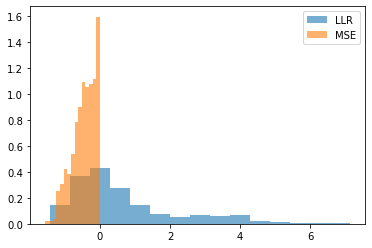

In [10]:
gen_data_ex = lambda : gen_data2(nobs=1000, a=.0)
mse_stats,llr_stats = plot_true2(gen_data_ex,setup_test)

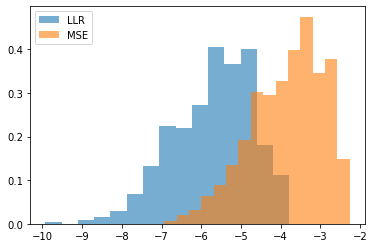

In [11]:
gen_data_ex = lambda : gen_data2(nobs=1000, a=.25)
mse_stats,llr_stats = plot_true2(gen_data_ex,setup_test)

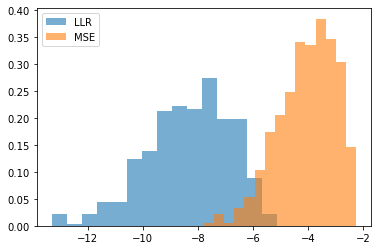

In [12]:
gen_data_ex = lambda : gen_data2(nobs=1000, a=.5)
mse_stats,llr_stats = plot_true2(gen_data_ex,setup_test)

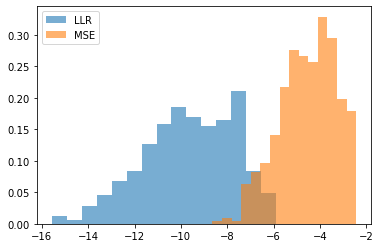

In [13]:
gen_data_ex = lambda : gen_data2(nobs=2000, a=.5)
mse_stats,llr_stats = plot_true2(gen_data_ex,setup_test)